<a href="https://www.kaggle.com/code/hazemesam/mask-detection?scriptVersionId=264426225" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage import exposure
import seaborn as sns


In [2]:
def resize_images(input_dir, size=(32, 32)):
    """
    Resize all images in the input directory to the specified size.
    """
    images = []
    for img_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            resized_img = cv2.resize(img, size)
            images.append(resized_img)
    return np.array(images)

# Resize images
X_with_mask = resize_images('/kaggle/input/face-mask-dataset/data/with_mask', size=(32, 32))
X_without_mask = resize_images('/kaggle/input/face-mask-dataset/data/without_mask', size=(32, 32))

# Normalize pixel values
X_with_mask = X_with_mask / 255.0 
X_without_mask = X_without_mask / 255.0

# Create labels
y_with_mask = np.ones(len(X_with_mask))  # Label 1 for 'with_mask'
y_without_mask = np.zeros(len(X_without_mask))  # Label 0 for 'without_mask'

# Combine images and labels
X = np.concatenate([X_with_mask, X_without_mask], axis=0)
y = np.concatenate([y_with_mask, y_without_mask], axis=0)

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)


In [3]:
# Split dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to categorical for classification
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [4]:
from skimage.feature import hog
from skimage import exposure

def extract_hog_features(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute HOG features
    fd, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
    
    # Rescale the HOG image to be in the range [0, 255]
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    return fd, hog_image_rescaled


              precision    recall  f1-score   support

           0       0.84      0.86      0.85       566
           1       0.85      0.84      0.85       567

    accuracy                           0.85      1133
   macro avg       0.85      0.85      0.85      1133
weighted avg       0.85      0.85      0.85      1133



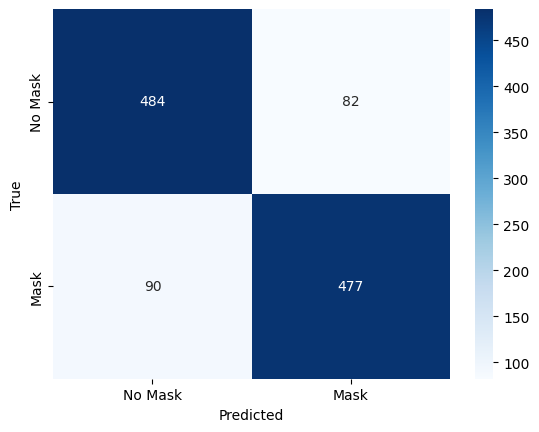

In [5]:

import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report

# Assuming X_train and X_test are numpy arrays of features
# If X_train is 3D or higher (e.g., images), flatten it
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Ensure y_train and y_test are properly formatted
y_train_flattened = y_train.argmax(axis=1)  # Convert one-hot encoded to class indices
y_test_flattened = y_test.argmax(axis=1)

# Train the SVM model with the flattened data
clf = svm.SVC(kernel='linear')
clf.fit(X_train_flattened, y_train_flattened)

# Evaluate the classifier
y_pred = clf.predict(X_test_flattened)

# Print accuracy and other metrics
print(classification_report(y_test_flattened, y_pred))


# Confusion Matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mask', 'Mask'], yticklabels=['No Mask', 'Mask'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_basic_cnn(input_shape=(32, 32, 3)):
    model = Sequential()
    
    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten the results
    model.add(Flatten())
    
    # Fully connected layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    
    # Output layer (Binary classification: mask/no mask)
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_mobilenetv2_model(input_shape=(32, 32, 3)):
    # Load pre-trained MobileNetV2 model without the top layer
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model to avoid retraining it
    base_model.trainable = False
    
    # Add a global average pooling layer and a fully connected layer
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    Input(shape=(32, 32, 3)),  # Explicit input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Binary classification (Mask/No Mask)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,690 (1.20 MB)

 Trainable params: 314,690 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16
)


Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7227 - loss: 0.5252 - val_accuracy: 0.8694 - val_loss: 0.3281
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8978 - loss: 0.2723 - val_accuracy: 0.9126 - val_loss: 0.2269
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9031 - loss: 0.2412 - val_accuracy: 0.9082 - val_loss: 0.2079
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9285 - loss: 0.1987 - val_accuracy: 0.9241 - val_loss: 0.2004
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9357 - loss: 0.1730 - val_accuracy: 0.9312 - val_loss: 0.1848
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9425 - loss: 0.1500 - val_accuracy: 0.9285 - val_loss: 0.1837
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9544 - loss: 0.1125 - val_accuracy: 0.9338 - val_loss: 0.1774
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9596 - loss: 0.1026 - val_accu

In [10]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Generate classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=['Without Mask', 'With Mask']))


36/36 - 0s - 7ms/step - accuracy: 0.9620 - loss: 0.1184
Test Accuracy: 96.20%
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

Without Mask       0.97      0.96      0.96       566
   With Mask       0.96      0.97      0.96       567

    accuracy                           0.96      1133
   macro avg       0.96      0.96      0.96      1133
weighted avg       0.96      0.96      0.96      1133



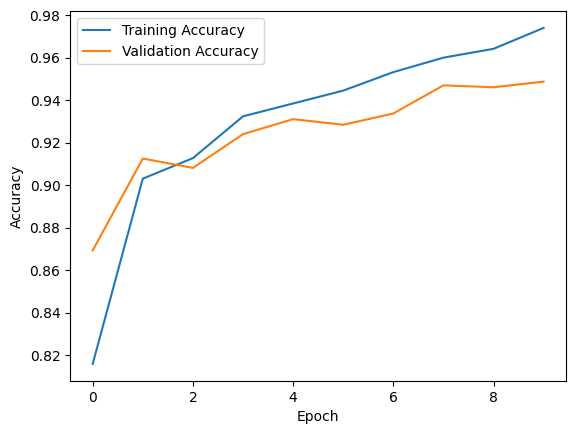

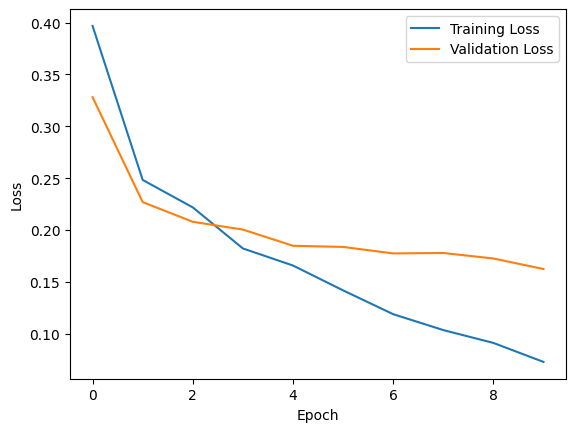

In [11]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


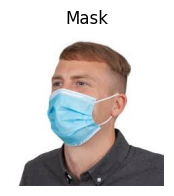

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


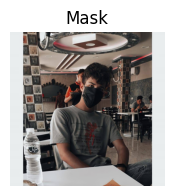

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


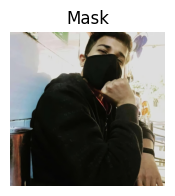

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


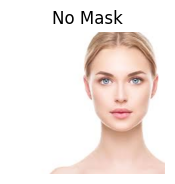

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


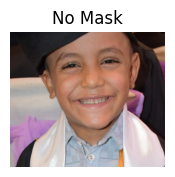

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


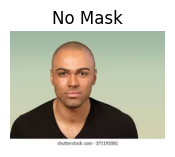

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


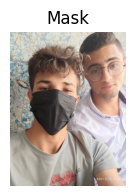

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


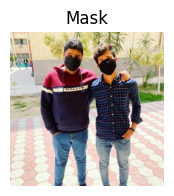

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


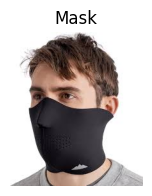

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


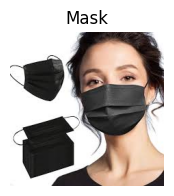

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


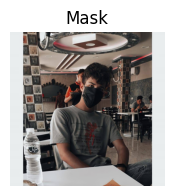

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


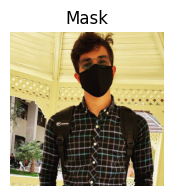

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


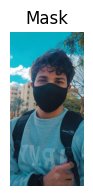

In [12]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def detect_mask(image, model):
    """
    Detect if a person is wearing a mask in a given image.
    """
    resized_img = cv2.resize(image, (32, 32)) / 255.0
    resized_img = np.expand_dims(resized_img, axis=0)
    prediction = np.argmax(model.predict(resized_img))
    return "Mask" if prediction == 1 else "No Mask"

# Set the directory containing test images
image_folder = "/kaggle/input/test-data/test2" # Replace with your folder path containing test images

# List all the images in the folder
image_files = os.listdir(image_folder)

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        continue
    
    label = detect_mask(image, model)
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    # Convert image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(2,2))
    # Display the image using matplotlib
    plt.imshow(image_rgb)
    plt.title(label)
    plt.axis('off')  # Hide axes
    plt.show()

